In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats

In [3]:
df = pd.read_csv('data/togo.csv')

In [4]:
# Summary and missing values
df.describe()
df.isna().sum()

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

In [6]:
# Handle missing values
# Fill only numeric columns to avoid trying to convert non-numeric columns (e.g. Timestamp)
num_cols = df.select_dtypes(include=[np.number]).columns
medians = df[num_cols].median()
df[num_cols] = df[num_cols].fillna(medians)

In [7]:
# Outlier detection
z_scores = np.abs(stats.zscore(df.select_dtypes('number')))
df = df[(z_scores < 3).all(axis=1)]

In [8]:
# Save cleaned data
df.to_csv('data/togo_clean.csv', index=False)

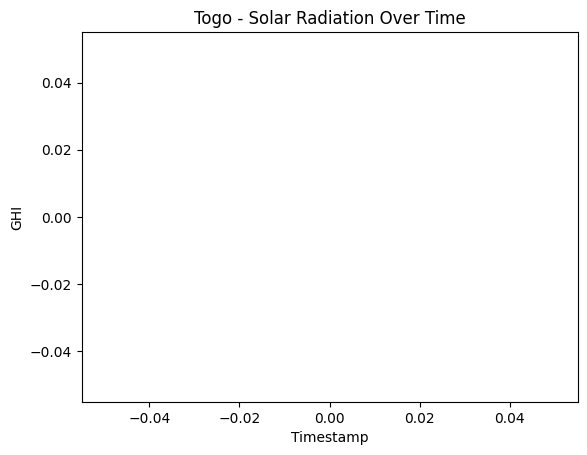

In [9]:
# Plot examples
sns.lineplot(x='Timestamp', y='GHI', data=df)
plt.title('Togo - Solar Radiation Over Time')
plt.show()

## Togo — Exploratory Data Analysis (EDA)

This notebook cell performs an end-to-end EDA for Togo solar dataset: summary statistics, missing-value report, outlier detection (Z-score), median imputation, cleaning impact analysis, time-series and distribution plots, correlation heatmap, scatterplots, a simple wind-rose, and a bubble chart. It will save a cleaned CSV to `data/togo_clean.csv` (ensure `data/` is in `.gitignore`).

In [11]:
# Togo EDA: summary, missing values, outliers (Z-score), median imputation, plots, and save cleaned CSV
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# --- Locate CSV ---
candidates = glob.glob('data/*togo*.csv') + glob.glob('data/*togo*.CSV')
if candidates:
    file_path = candidates[0]
else:
    # fallback names
    for name in ('data/togo_data.csv', 'data/togo.csv', 'data/Togo.csv'):
        if os.path.exists(name):
            file_path = name
            break
    else:
        raise FileNotFoundError('No Togo CSV found in data/. Place the file as data/togo_data.csv or similar.')

print(f'Loading: {file_path}')
df = pd.read_csv(file_path)
print('Shape:', df.shape)

# Keep a copy before cleaning for comparison
df_before = df.copy()

Loading: data\togo.csv
Shape: (525600, 19)
Shape: (525600, 19)


In [12]:
# --- Summary statistics & missing-value report ---
numeric = df.select_dtypes(include=[np.number])
print('\nNumeric describe:\n')
print(numeric.describe().T)

missing = df.isna().sum()
null_pct = (df.isna().mean() * 100)
cols_gt5 = null_pct[null_pct > 5].sort_values(ascending=False)
print('\nMissing values (count):\n', missing[missing > 0])
print('\nColumns with >5% nulls:\n', cols_gt5)



Numeric describe:

                  count        mean         std    min    25%    50%      75%  \
GHI            525600.0  230.555040  322.532347  -12.7   -2.2    2.1  442.400   
DNI            525600.0  151.258469  250.956962    0.0    0.0    0.0  246.400   
DHI            525600.0  116.444352  156.520714    0.0    0.0    2.5  215.700   
ModA           525600.0  226.144375  317.346938    0.0    0.0    4.4  422.525   
ModB           525600.0  219.568588  307.932510    0.0    0.0    4.3  411.000   
Tamb           525600.0   27.751788    4.758023   14.9   24.2   27.2   31.100   
RH             525600.0   55.013160   28.778732    3.3   26.5   59.3   80.800   
WS             525600.0    2.368093    1.462668    0.0    1.4    2.2    3.200   
WSgust         525600.0    3.229490    1.882565    0.0    1.9    2.9    4.400   
WSstdev        525600.0    0.557740    0.268923    0.0    0.4    0.5    0.700   
WD             525600.0  161.741845   91.877217    0.0   74.8  199.1  233.500   
WDstdev 

In [13]:
# --- Outlier detection (Z-score) for selected columns ---
check_cols = [c for c in ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust'] if c in df.columns]
print('\nColumns used for Z-score outlier detection:', check_cols)

if check_cols:
    z = (df[check_cols] - df[check_cols].mean()) / df[check_cols].std(ddof=0)
    outlier_mask = (z.abs() > 3).any(axis=1)
    df['outlier_z'] = outlier_mask
    print('Outliers flagged (Z>|3|):', outlier_mask.sum())
else:
    df['outlier_z'] = False


Columns used for Z-score outlier detection: ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
Outliers flagged (Z>|3|): 9251
Outliers flagged (Z>|3|): 9251


In [14]:
# --- Drop or impute missing values (median) in key columns ---
key_columns = [c for c in ['GHI', 'DNI', 'DHI', 'ModA', 'ModB'] if c in df.columns]
print('\nKey columns for median imputation:', key_columns)
for col in key_columns:
    median = df[col].median()
    df[col] = df[col].fillna(median)

# If WS or WSgust are present, medians too
for col in ['WS', 'WSgust']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())


Key columns for median imputation: ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']


In [ ]:
# --- Export cleaned DataFrame ---
os.makedirs('data', exist_ok=True)
cleaned_path = 'data/togo_clean.csv'
df.to_csv(cleaned_path, index=False)
print('\nCleaned data saved to', cleaned_path)
print('Note: ensure data/ is in .gitignore to avoid committing CSVs.')

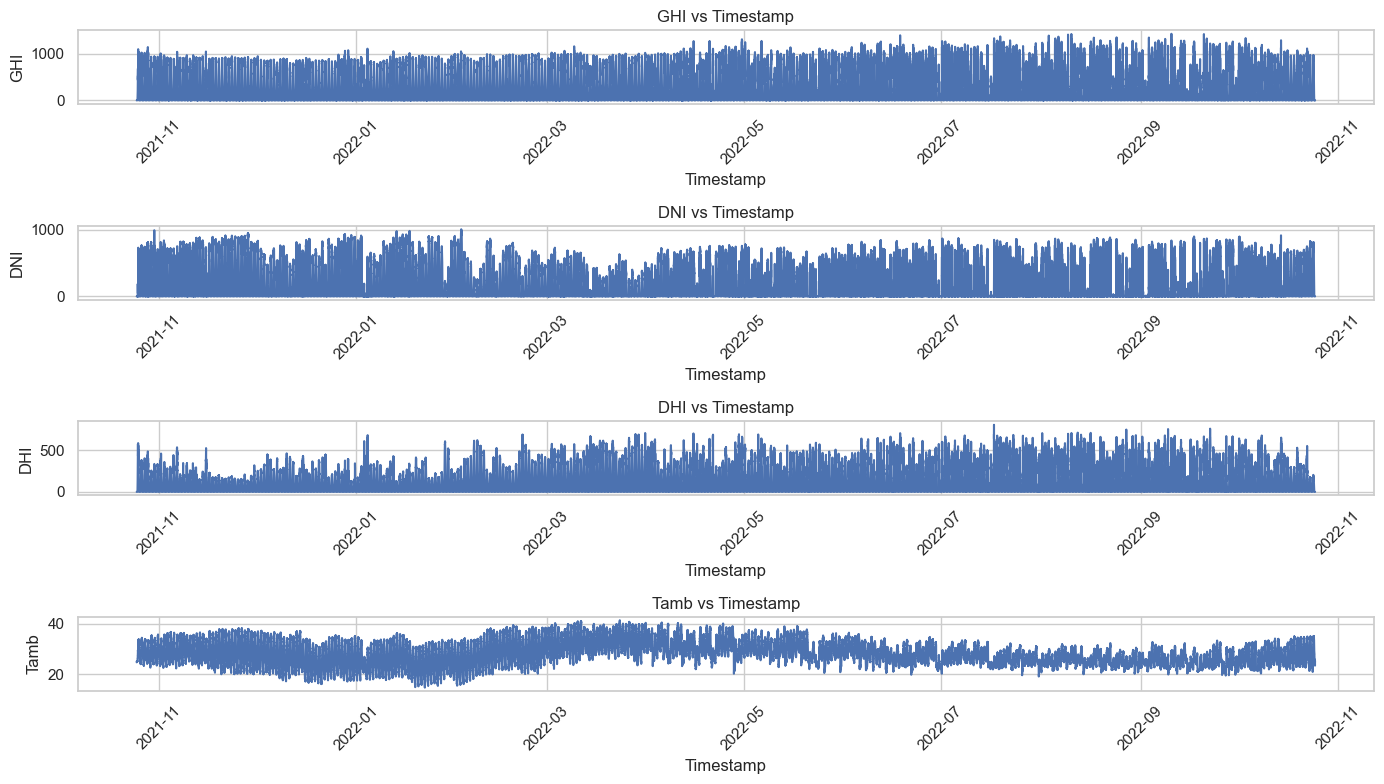

In [15]:
# --- Time series analysis ---
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
else:
    # try to guess a date column
    possible = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
    if possible:
        df['Timestamp'] = pd.to_datetime(df[possible[0]], errors='coerce')
    else:
        print('No Timestamp column found — time series plots will try index-based plots.')

# Plot GHI, DNI, DHI, Tamb vs Timestamp if present
plt.figure(figsize=(14, 8))
plot_cols = [c for c in ['GHI', 'DNI', 'DHI', 'Tamb'] if c in df.columns]
if 'Timestamp' in df.columns and not df['Timestamp'].isna().all():
    for i, col in enumerate(plot_cols, 1):
        plt.subplot(len(plot_cols), 1, i)
        plt.plot(df['Timestamp'], df[col], label=col)
        plt.title(f'{col} vs Timestamp')
        plt.xlabel('Timestamp')
        plt.ylabel(col)
        plt.xticks(rotation=45)
        plt.tight_layout()
    plt.show()
else:
    # index based quick plot
    df[plot_cols].head(300).plot(subplots=True, figsize=(12, 8), title='First 300 rows (index-based)')
    plt.show()

C:\Users\BIOS\AppData\Local\Temp\ipykernel_1744\3023057352.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_ts['GHI'].resample('M').mean().plot(marker='o', title='Monthly mean GHI')


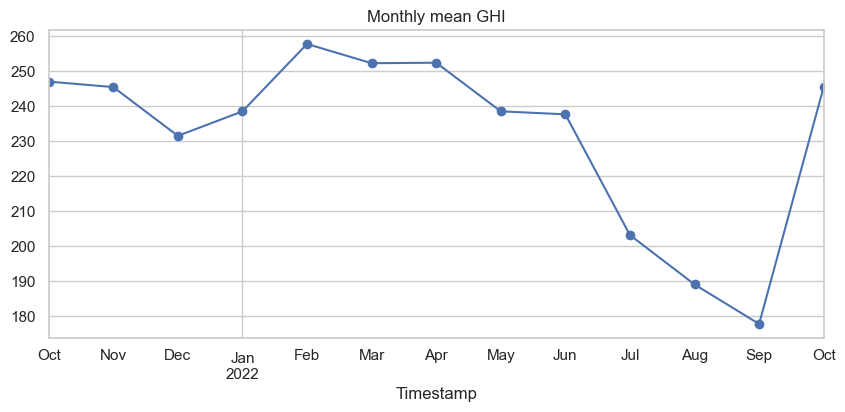

C:\Users\BIOS\AppData\Local\Temp\ipykernel_1744\3023057352.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=df, x='hour', y='GHI', ci='sd')


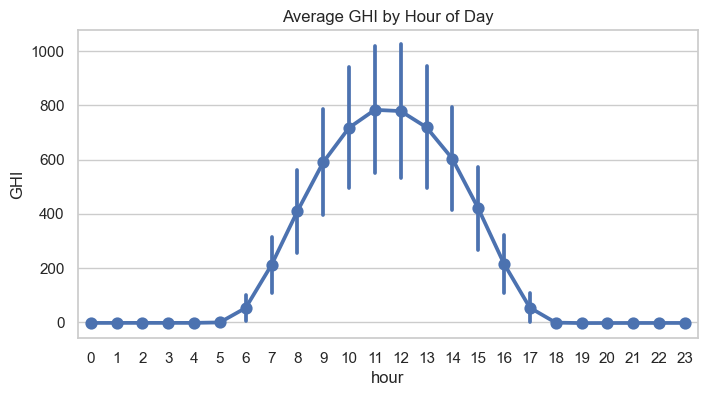

In [16]:
# Month and hour patterns (if Timestamp exists)
if 'Timestamp' in df.columns and not df['Timestamp'].isna().all():
    df_ts = df.set_index('Timestamp')
    if 'GHI' in df.columns:
        plt.figure(figsize=(10,4))
        df_ts['GHI'].resample('M').mean().plot(marker='o', title='Monthly mean GHI')
        plt.show()
    # daily cycle by hour
    if 'GHI' in df.columns:
        df['hour'] = df['Timestamp'].dt.hour
        plt.figure(figsize=(8,4))
        sns.pointplot(data=df, x='hour', y='GHI', ci='sd')
        plt.title('Average GHI by Hour of Day')
        plt.show()



Median values pre-imputation:
 ModA    4.4
ModB    4.3
dtype: float64

Median values post-imputation:
 ModA    4.4
ModB    4.3
dtype: float64


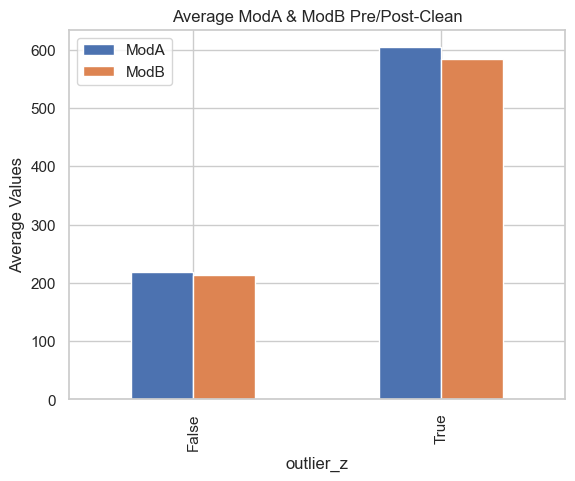

In [17]:
# --- Cleaning impact: ModA & ModB pre/post clean ---
mod_cols = [c for c in ['ModA', 'ModB'] if c in df.columns]
if mod_cols:
    pre = df_before[mod_cols].median()
    post = df[mod_cols].median()
    print('\nMedian values pre-imputation:\n', pre)
    print('\nMedian values post-imputation:\n', post)
    try:
        df_before['outlier_z'] = df['outlier_z']
        grouped = df_before.groupby('outlier_z')[mod_cols].mean()
        grouped.plot(kind='bar', title='Average ModA & ModB Pre/Post-Clean')
        plt.ylabel('Average Values')
        plt.show()
    except Exception as e:
        print('Could not plot ModA/ModB pre/post clean:', e)

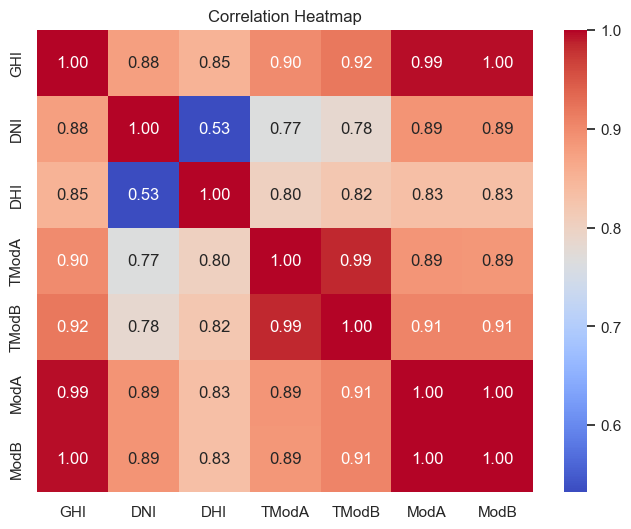

In [18]:
# --- Correlation heatmap ---
corr_cols = [c for c in ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'ModA', 'ModB'] if c in df.columns]
if corr_cols:
    cm = df[corr_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

### Scatter plots 

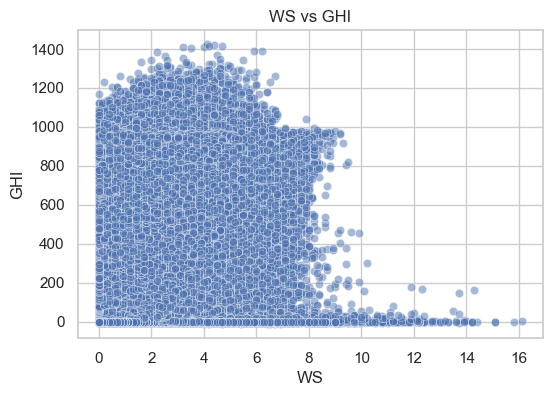

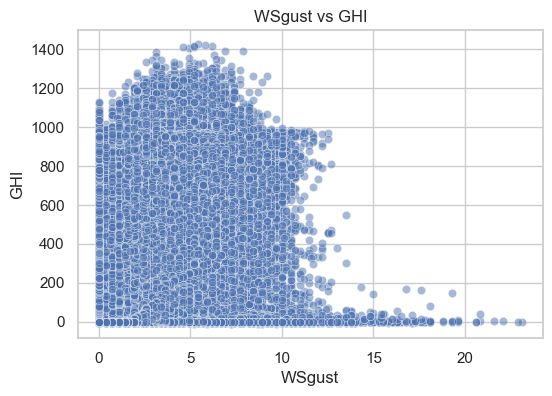

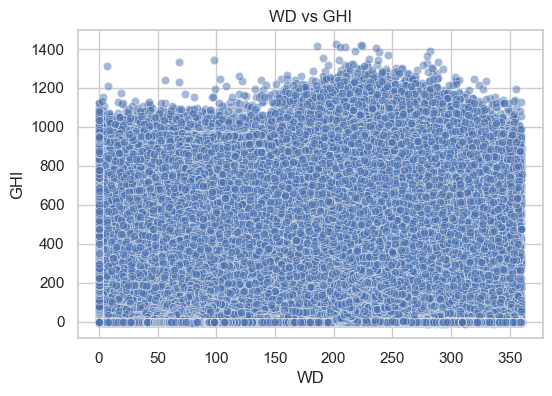

In [19]:

# WS, WSgust, WD vs GHI
for x in ['WS', 'WSgust', 'WD']:
    if x in df.columns and 'GHI' in df.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(data=df, x=x, y='GHI', alpha=0.5)
        plt.title(f'{x} vs GHI')
        plt.show()

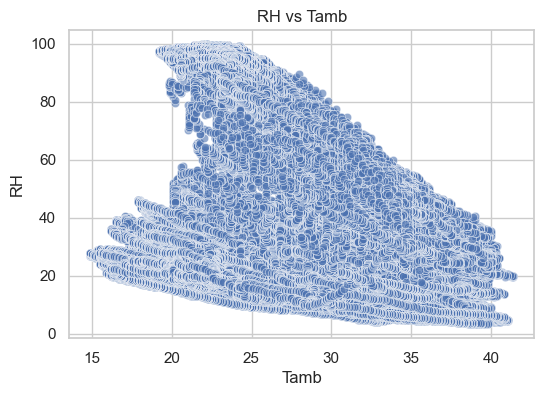

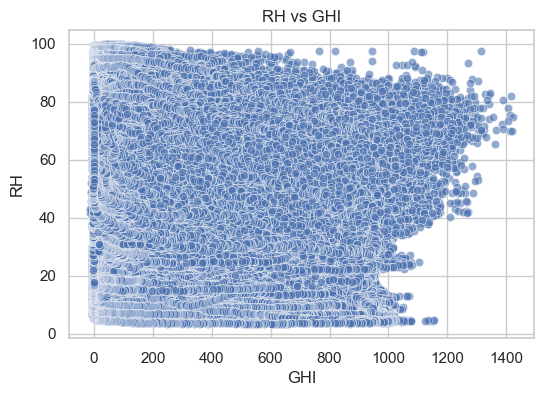

In [20]:

# RH vs Tamb or RH vs GHI
if 'RH' in df.columns and 'Tamb' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x='Tamb', y='RH', alpha=0.6)
    plt.title('RH vs Tamb')
    plt.show()

if 'RH' in df.columns and 'GHI' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x='GHI', y='RH', alpha=0.6)
    plt.title('RH vs GHI')
    plt.show()

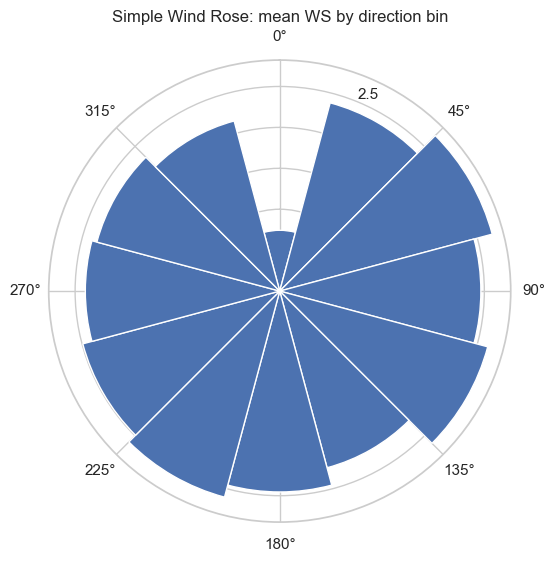

In [21]:
# --- Wind rose (simple polar bar) ---
if 'WD' in df.columns and 'WS' in df.columns:
    try:
        # make direction bins of 30 deg
        bins = np.arange(0, 360, 30)
        labels = (bins + 15)[:-0]
        df['dir_bin'] = (df['WD'] // 30).fillna(-1).astype(int)
        ws_by_bin = df.groupby('dir_bin')['WS'].mean().reindex(range(12), fill_value=0)
        theta = np.deg2rad(np.arange(0, 360, 30))
        widths = np.deg2rad(30)
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, polar=True)
        bars = ax.bar(theta, ws_by_bin.values, width=widths, bottom=0)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_title('Simple Wind Rose: mean WS by direction bin')
        plt.show()
    except Exception as e:
        print('Wind rose failed:', e)

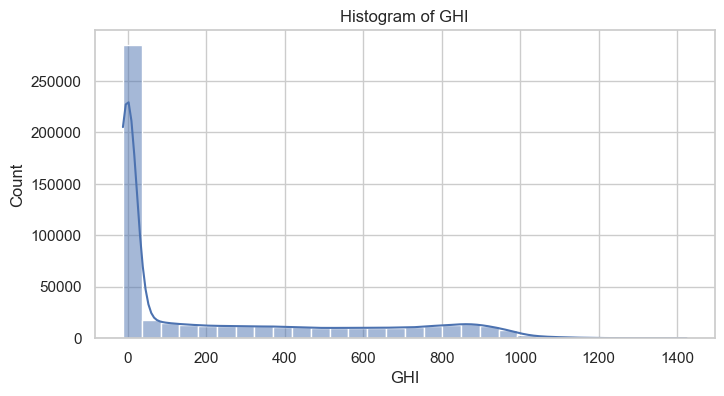

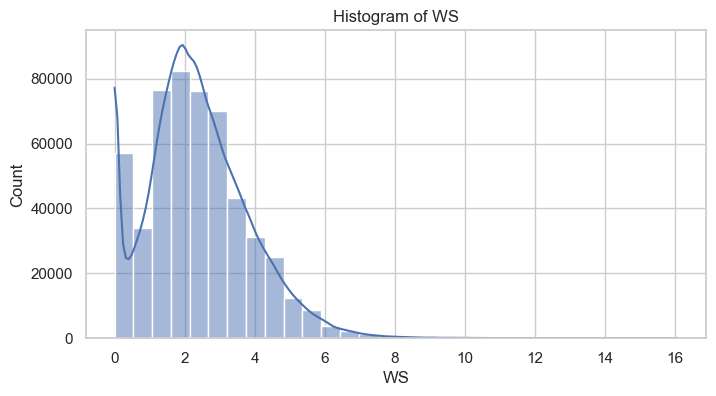

In [22]:
# --- Histograms ---
if 'GHI' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['GHI'].dropna(), bins=30, kde=True)
    plt.title('Histogram of GHI')
    plt.show()

other_hist = 'WS' if 'WS' in df.columns else ( 'ModA' if 'ModA' in df.columns else None)
if other_hist:
    plt.figure(figsize=(8,4))
    sns.histplot(df[other_hist].dropna(), bins=30, kde=True)
    plt.title(f'Histogram of {other_hist}')
    plt.show()

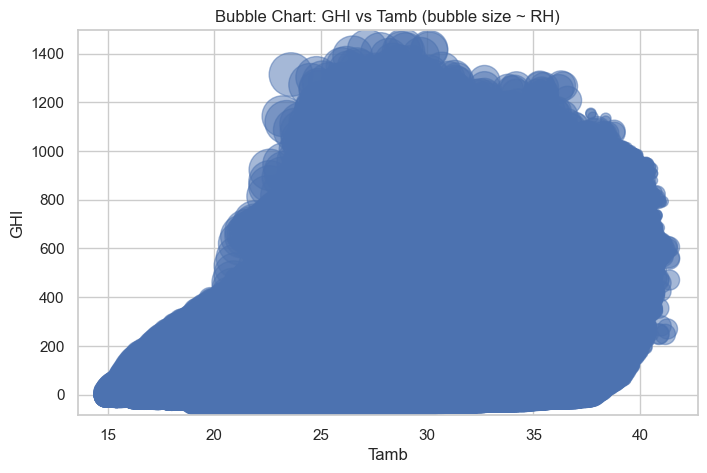

In [23]:
# --- Bubble chart: GHI vs Tamb, size=RH ---
if 'GHI' in df.columns and 'Tamb' in df.columns:
    size_col = 'RH' if 'RH' in df.columns else None
    sizes = (df[size_col].fillna(0).clip(lower=0) + 1) * 10 if size_col else 30
    plt.figure(figsize=(8,5))
    plt.scatter(df['Tamb'], df['GHI'], s=sizes, alpha=0.5)
    plt.xlabel('Tamb')
    plt.ylabel('GHI')
    plt.title('Bubble Chart: GHI vs Tamb (bubble size ~ RH)')
    plt.show()